In [119]:
!pip install --upgrade git+https://github.com/goolig/dsClass.git
from dsClass.path_helper import *

  Cloning https://github.com/goolig/dsClass.git to /tmp/pip-req-build-ga5k7t7g
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [120]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Explainable AI Exercise

[SHAP documentation](https://shap.readthedocs.io/en/latest/)

## The Dataset

In [121]:
file_name = get_file_path("bank.csv")
df = pd.read_csv(file_name)
# Get X, y
y = df["y"].map({"no": 0, "yes": 1})
X = df.drop("y", axis=1)

num_features = ["age", "campaign", "pdays", "previous"]

cat_features = ["job", "marital", "education","default", "housing", "loan", "contact", 
                "month", "day_of_week", "poutcome"]

In [122]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent


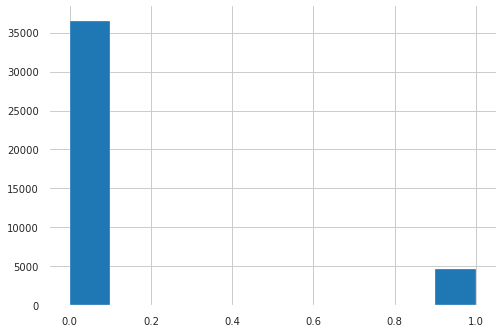

In [123]:
y.hist()

Description of features:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
12. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
13. previous: number of contacts performed before this campaign and for this client (numeric)
14. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

In [124]:
from pandas_profiling import ProfileReport
report = ProfileReport(df, title='Bank dataset')
report

Consider using IPython.display.IFrame instead


In [125]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)
                                                        #stratify = y : for unbalanced data we do this so the test and train will get equal amount of every instance of y ( our case 0 or 1)
                                                        #if we dont do this, maybe all the y=1 will be in the test and the model wont predict correctly

## Create a preprocessing pipeline

In [126]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

In [127]:
# Train preprocessor
preprocessor.fit(X_train)

# Get the list of categories generated by the process
ohe_categories = preprocessor.named_transformers_["categorical"].categories_

# Create names for our one hot encoded features
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]

# Create a new list with all names of features
all_features = num_features + new_ohe_features

# Save processed data
X_train_processed = pd.DataFrame(preprocessor.transform(X_train), columns=all_features)
X_test_processed = pd.DataFrame(preprocessor.transform(X_test), columns=all_features)

## Fit models

Use sklearn (already imported) to create a random forest, and fit them on the training data. 

In [128]:
#addition
# create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=150, n_jobs=-1, 
                                                      min_samples_split=.01, max_depth=15,
                                                      random_state=42)
#fit model
rf_model.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=0.01, n_estimators=150,
                       n_jobs=-1, random_state=42)

In [129]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
predictions = rf_model.predict(X_test_processed)
print(confusion_matrix(y_test, predictions))
print('Random forest model accuracy score: {0:0.3f}'. format(accuracy_score(y_test, predictions)))

print(f'Random forest model full classification report:\n{classification_report(y_test, predictions)}')

[[10858   107]
 [ 1127   265]]
Random forest model accuracy score: 0.900
Random forest model full classification report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10965
           1       0.71      0.19      0.30      1392

    accuracy                           0.90     12357
   macro avg       0.81      0.59      0.62     12357
weighted avg       0.88      0.90      0.87     12357



## SHAP to interpret local predictions

In [130]:
import shap
# Need to load JS vis in the notebook
shap.initjs() 

### Create an explainer

The parameter passed to the explainer is the trained random forest model

In [131]:
# create a tree explainer
explainer = shap.TreeExplainer(rf_model, X_train_processed)

#### Explain one observation

In [132]:
i = 4

observation = X_test_processed.iloc[[i]]
print(f"Observation true label: {y_test.iloc[i]}")
print(f"Observation predicted label (proba): {rf_model.predict_proba(observation)[0]}")

observation

Observation true label: 1
Observation predicted label (proba): [0.41977732 0.58022268]


,age,campaign,pdays,previous,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,...,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,poutcome__failure,poutcome__nonexistent,poutcome__success
4,27.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


calculate shap values and plot chart

## Explain a specific observation using SHAP
Use SHAP to claculate the SHAP values for the defined observation (look into the documentation) 

In [133]:
#calculate shap values
shap_values = explainer.shap_values(observation)

In [134]:
shap_values

[array([[-3.86388921e-03,  1.40594474e-02, -1.62039674e-01,
         -6.12959813e-02,  5.38809877e-04, -3.03003779e-03,
         -1.26681761e-03, -5.88952361e-05,  1.29059879e-04,
          2.93183978e-05, -2.99570038e-04, -5.97069326e-04,
          0.00000000e+00, -9.02760598e-05, -2.46362595e-05,
          2.42345025e-04,  1.90127046e-04, -1.74283553e-03,
         -4.14057892e-03,  0.00000000e+00, -2.90609794e-04,
         -2.14804533e-04, -1.47621289e-03, -1.06012180e-03,
          0.00000000e+00, -1.64788888e-04, -2.42834477e-03,
          0.00000000e+00, -7.90054931e-03, -4.32850233e-03,
          0.00000000e+00,  3.56104990e-04,  3.38921715e-05,
          4.30084625e-04,  2.73859391e-04,  4.99254080e-05,
          1.27898956e-04, -9.01839738e-03, -8.95476627e-03,
          5.32539007e-05, -5.44132755e-04,  0.00000000e+00,
          1.17029176e-03, -3.54283320e-02,  5.20723987e-03,
         -9.47764283e-03, -1.50403009e-03,  1.54518751e-03,
          1.98508469e-03, -3.69860618e-0

In [135]:
len(shap_values)

2

In [136]:
#plot chart
shap.force_plot(explainer.expected_value[1], shap_values[1], observation)

In [137]:
i = 100

observation = X_test_processed.iloc[[i]]
print(f"Observation true label: {y_test.iloc[i]}")
print(f"Observation predicted label (proba): {rf_model.predict_proba(observation)[0]}")

#calculate shap values
shap_values = explainer.shap_values(observation)
#plot chart for another observation
shap.force_plot(explainer.expected_value[1], shap_values[1], observation)

Observation true label: 1
Observation predicted label (proba): [0.95335378 0.04664622]


In [138]:
#sample 5000 observations from the test data
observations = X_test_processed.sample(5000, random_state=15)


## Explain the model - Summary plot

100%|===================| 9992/10000 [03:20<00:00]        

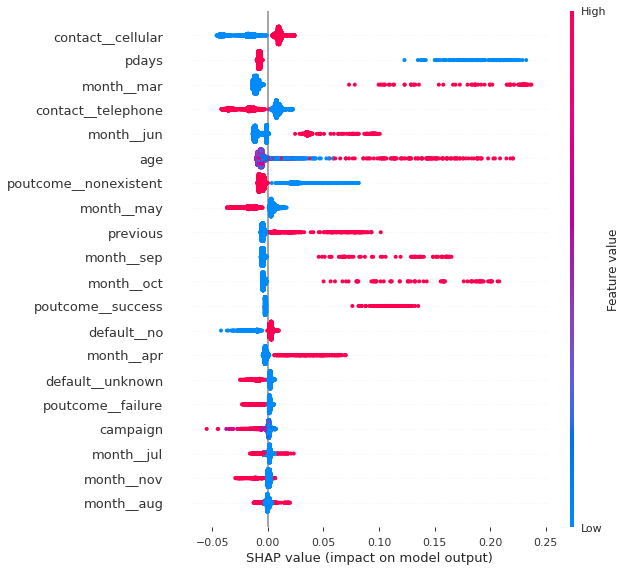

In [139]:
#calculate shap values
shap_values = explainer.shap_values(observations)
shap.summary_plot(shap_values[1], features=observations)

In [140]:
shap_values

[array([[ 7.39877765e-03,  9.32607246e-03,  8.35918539e-03, ...,
          1.91886392e-02, -2.32327156e-02,  2.24917157e-03],
        [ 6.46577620e-03,  5.93449797e-03,  7.88375908e-03, ...,
         -1.78353312e-03,  4.47163659e-03,  2.05762860e-03],
        [-6.60463333e-03, -1.01964342e-03,  8.06108236e-03, ...,
         -1.69443137e-03,  7.03167417e-03,  2.24362429e-03],
        ...,
        [ 3.76816006e-03, -5.08911376e-04,  8.60960639e-03, ...,
         -1.81707686e-03,  5.15244241e-03,  2.26388045e-03],
        [ 7.00214022e-03,  1.24159377e-05,  8.43405751e-03, ...,
         -1.88086342e-03,  4.70112871e-03,  2.33115409e-03],
        [ 5.06048721e-03,  1.80908879e-05,  7.97574985e-03, ...,
         -1.47724540e-03,  5.88293206e-03,  1.79377323e-03]]),
 array([[-7.39877734e-03, -9.32607313e-03, -8.35918514e-03, ...,
         -1.91886403e-02,  2.32327144e-02, -2.24917152e-03],
        [-6.46577542e-03, -5.93449899e-03, -7.88375886e-03, ...,
          1.78353320e-03, -4.47163634e

### Q1: Check how the instances with a low 'pdays' distribute between the classes? 

In [141]:
#Q1
#we can see from the plot that high pdays (pdays = 999 which means they didn't got called) will be in class 0 which means will not accept the proposal.
#we can see also that low pdays will be in class 1 which means we will accept the proposal.

Get only the instances from class 1

In [142]:
#Only class 1
X_1 = X_test[(y_test==1)]
X_1_test_processed = pd.DataFrame(preprocessor.transform(X_1), columns=all_features)

## Summary plot only for class 1

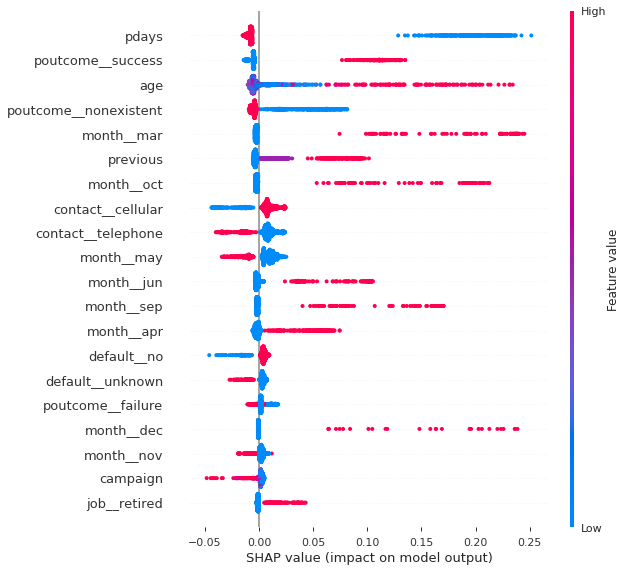

In [143]:
shap_values = shap.TreeExplainer(rf_model).shap_values(X_1_test_processed)
shap.summary_plot(shap_values[1], features=X_1_test_processed)

Summary plot only for class 0

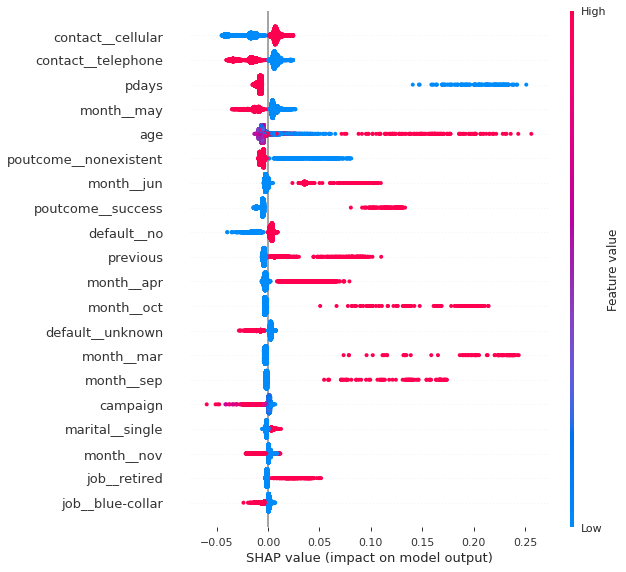

In [144]:
#Only class 0
X_0 = X_test[(y_test==0)]
X_0_test_processed = pd.DataFrame(preprocessor.transform(X_0), columns=all_features)
shap_values = shap.TreeExplainer(rf_model).shap_values(X_0_test_processed)
shap.summary_plot(shap_values[1], features=X_0_test_processed)

## Generate a summary plot only for class 1 that was predicted 0

In [145]:
#Get all False negatives
y_pred_test_1 = rf_model.predict(X_test_processed)
X_fn = X_test[(y_test==1) & (y_pred_test_1==0)]
X_fn_test_processed = pd.DataFrame(preprocessor.transform(X_fn), columns=all_features)

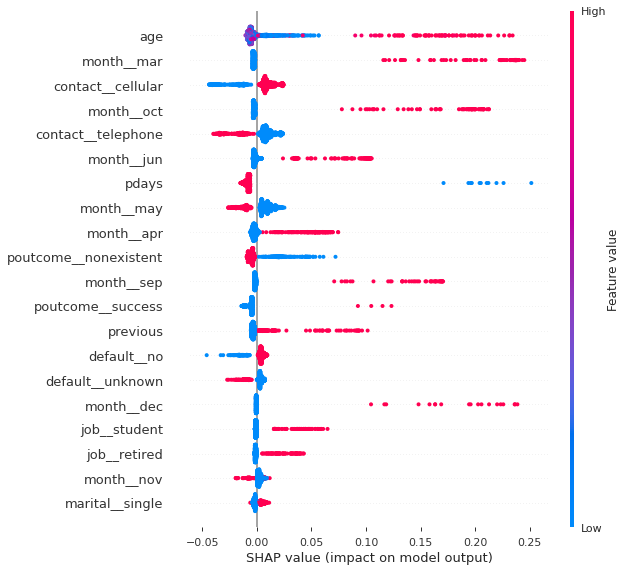

In [146]:
#Create a summary plot only for false negatives
shap_values = shap.TreeExplainer(rf_model).shap_values(X_fn_test_processed)
shap.summary_plot(shap_values[1], features=X_fn_test_processed)

### Q2: Create a summary plot only for the true positives (in class 1). Write some insights about the difference in the top features between the TP and FN

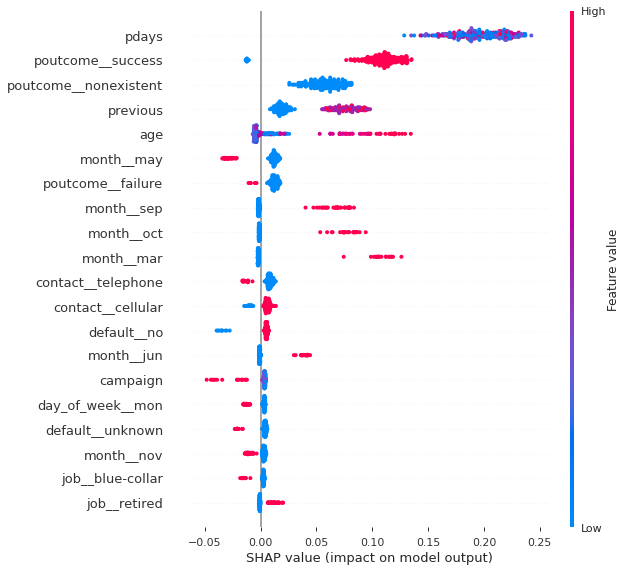

In [147]:
#Q2
#Get all TP
y_pred_test_1_1 = rf_model.predict(X_test_processed)
X_tp = X_test[(y_test==1) & (y_pred_test_1_1==1)]
X_tp_test_processed = pd.DataFrame(preprocessor.transform(X_tp), columns=all_features)
#Create a summary plot only for TP
shap_values = shap.TreeExplainer(rf_model).shap_values(X_tp_test_processed)
shap.summary_plot(shap_values[1], features=X_tp_test_processed)

In [148]:
#Insigths:
#we can see that poutcome_success jumped really high comparing to the FN graph,
#also he classified the outcome according to the nonexistent and success pretty good in TP and not in FN
#In the FN graph the model thought that buying in march can be a really good inidcator to the decision and in the TP it didnt think so.
#In the FN graph the distibution of the pdays between the red and blue is vary distinct. In the TP graph its not so distinct.

## Q3 
### a. Train a xgboost classifier. 
### b. Evaluate it with metrics that represent how good the classifier is in predicting instances from class 1. 
### c. Explain why did you choose these metrics.

In [149]:
#Q3
from xgboost import XGBClassifier
xgbModel = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgbModel.fit(X_train_processed, y_train)

[22:00:13] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [150]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
predictions = xgbModel.predict(X_test_processed)

print(confusion_matrix(y_test, predictions))
print('XGBoost accuracy score: {0:0.3f}'. format(accuracy_score(y_test, predictions)))

print(f'XGBoost model full classification report:\n{classification_report(y_test, predictions)}')

[[10750   215]
 [ 1078   314]]
XGBoost accuracy score: 0.895
XGBoost model full classification report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10965
           1       0.59      0.23      0.33      1392

    accuracy                           0.90     12357
   macro avg       0.75      0.60      0.64     12357
weighted avg       0.87      0.90      0.87     12357



#precision = TP / (TP + FP)

#recall = TP / (TP + FN)

#F1-score = 2*(recall*precision)/(recall+precision)

#F1 is a better scoring metric than others when dealing with imbalanced data when more attention is needed on the positives.

## Q4: Create a tree explainer and repeat the process we did earlier in the notebook, this time with xgboost (all the forceplots and summary plots)

In [151]:
# create a tree explainer
xgbExplainer = shap.TreeExplainer(xgbModel, X_train_processed)

In [152]:
i = 4

observation = X_test_processed.iloc[[i]]
print(f"Observation true label: {y_test.iloc[i]}")
print(f"Observation predicted label (proba): {rf_model.predict_proba(observation)[0]}")

observation

Observation true label: 1
Observation predicted label (proba): [0.41977732 0.58022268]


,age,campaign,pdays,previous,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,...,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,poutcome__failure,poutcome__nonexistent,poutcome__success
4,27.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [153]:
shap.initjs()

In [154]:
i = 100

observation = X_test_processed.iloc[[i]]
print(f"Observation true label: {y_test.iloc[i]}")
print(f"Observation predicted label (proba): {rf_model.predict_proba(observation)[0]}")

#calculate shap values
shap_values = xgbExplainer.shap_values(observation)
#plot chart for another observation
shap.force_plot(xgbExplainer.expected_value, shap_values, observation)

Observation true label: 1
Observation predicted label (proba): [0.95335378 0.04664622]


In [155]:
#sample 5000 observations from the test data
observations = X_test_processed.sample(5000, random_state=15)
observations

,age,campaign,pdays,previous,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,...,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,poutcome__failure,poutcome__nonexistent,poutcome__success
6783,37.0,5.0,999.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
298,35.0,5.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2303,26.0,2.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
612,45.0,3.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10315,33.0,1.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11081,43.0,2.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
12279,33.0,2.0,999.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2128,51.0,2.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11438,41.0,2.0,999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [156]:
#calculate shap values
shap_values = xgbExplainer.shap_values(observations)
shap_values

 98%|===================| 4887/5000 [00:17<00:00]        

array([[-0.38745385, -0.35943693, -0.05220469, ...,  0.00138552,
         0.        , -0.00703019],
       [ 0.0533317 , -0.6737282 , -0.05475763, ...,  0.03945401,
         0.        , -0.00379693],
       [ 0.22850882,  0.12482639, -0.07296533, ..., -0.03504903,
         0.        , -0.00886044],
       ...,
       [ 0.3265083 ,  0.08648672, -0.08735318, ...,  0.0349125 ,
         0.        , -0.0031956 ],
       [-0.10019504,  0.0328259 , -0.09134943, ...,  0.03473465,
         0.        , -0.00312734],
       [-0.18249067,  0.02461385, -0.0710027 , ..., -0.03910453,
         0.        , -0.00405404]])

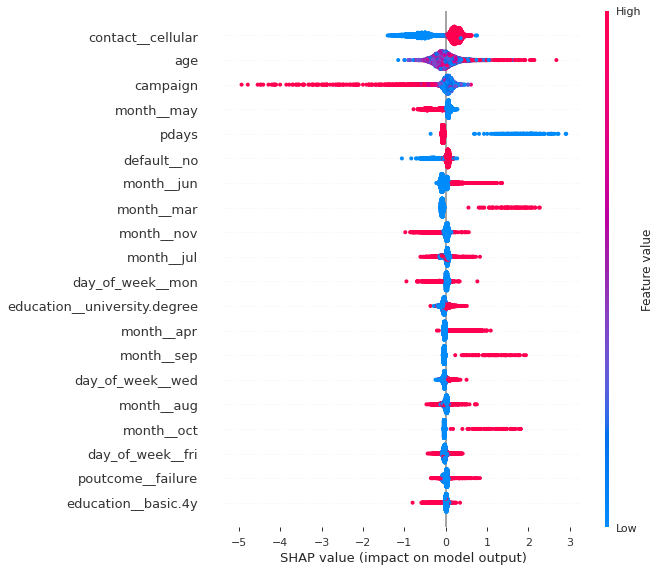

In [157]:
shap.summary_plot(shap_values, features=observations)

## Only for class 1

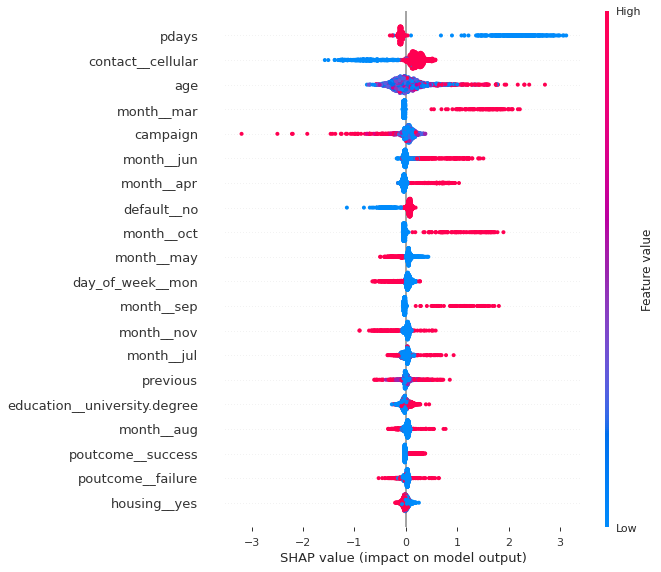

In [158]:
X_1 = X_test[(y_test==1)]
X_1_test_processed = pd.DataFrame(preprocessor.transform(X_1), columns=all_features)
shap_values = shap.TreeExplainer(xgbModel).shap_values(X_1_test_processed)
shap.summary_plot(shap_values, features=X_1_test_processed)

## Only for Class 0

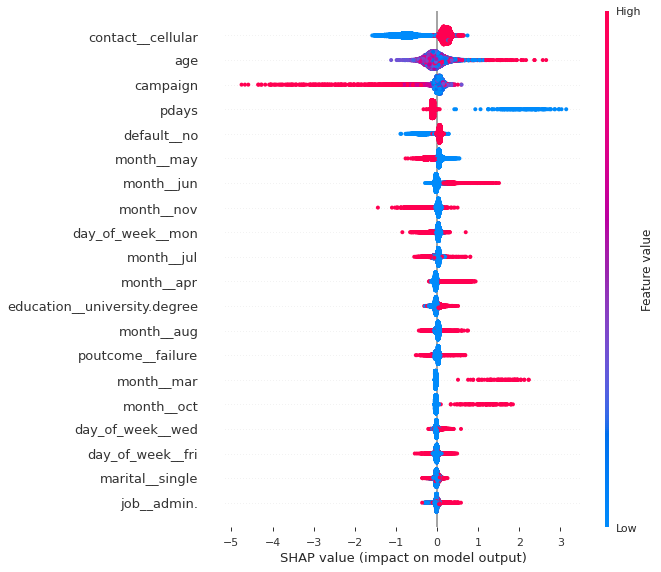

In [159]:
X_0 = X_test[(y_test==0)]
X_0_test_processed = pd.DataFrame(preprocessor.transform(X_0), columns=all_features)
shap_values = shap.TreeExplainer(xgbModel).shap_values(X_0_test_processed)
shap.summary_plot(shap_values, features=X_0_test_processed)

## False Negative

In [160]:
#Get all False negatives
y_pred_test_1 = xgbModel.predict(X_test_processed)
X_fn = X_test[(y_test==1) & (y_pred_test_1==0)]
X_fn_test_processed = pd.DataFrame(preprocessor.transform(X_fn), columns=all_features)

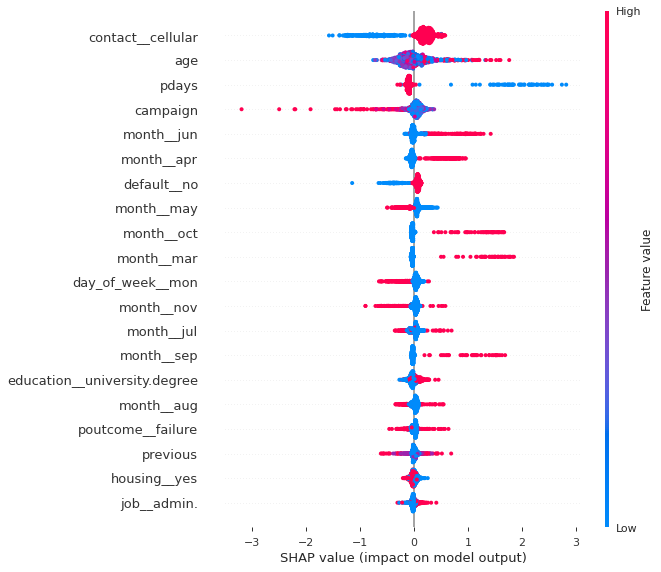

In [161]:
#Create a summary plot only for false negatives
shap_values = shap.TreeExplainer(xgbModel).shap_values(X_fn_test_processed)
shap.summary_plot(shap_values, features=X_fn_test_processed)

## True Positive

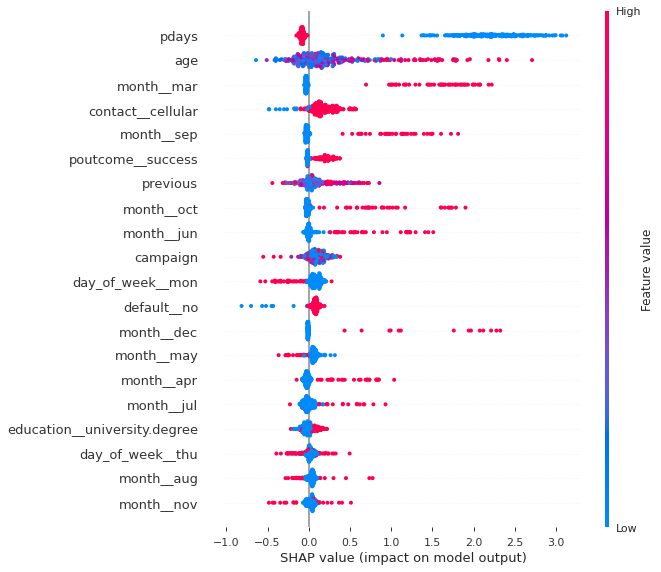

In [162]:
#Get all TP
y_pred_test_1_1 = xgbModel.predict(X_test_processed)
X_tp = X_test[(y_test==1) & (y_pred_test_1_1==1)]
X_tp_test_processed = pd.DataFrame(preprocessor.transform(X_tp), columns=all_features)
#Create a summary plot only for TP
shap_values = shap.TreeExplainer(xgbModel).shap_values(X_tp_test_processed)
shap.summary_plot(shap_values, features=X_tp_test_processed)

# Q5
Compare the top features in the summary plots between the false negatives and true positives. Then,try to change something in the input features and explain why did you do it. Train the model again and evaluate it. Write in words how this change affected the performance of the model.

Good luck!

## Solution:
### We will try to delete age. We can see that the age disribution of red and blue is quite large in both TP and FN
### We can understand from this that maybe the age had nothing to do with the decision the person did!

In [163]:
X_train_processed_no_age = X_train_processed.drop('age', axis = 1)
X_train_processed_no_age 
X_test_processed_no_age = X_test_processed.drop('age', axis = 1)
X_test_processed_no_age 

,campaign,pdays,previous,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,job__self-employed,...,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,poutcome__failure,poutcome__nonexistent,poutcome__success
0,1.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12352,1.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12353,1.0,999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12354,2.0,999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12355,2.0,999.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [164]:
from xgboost import XGBClassifier
xgbModel = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgbModel.fit(X_train_processed_no_age, y_train)

[22:00:46] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [165]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
predictions = xgbModel.predict(X_test_processed_no_age)

print(confusion_matrix(y_test, predictions))
print('XGBoost accuracy score: {0:0.3f}'. format(accuracy_score(y_test, predictions)))

print(f'XGBoost model full classification report:\n{classification_report(y_test, predictions)}')

[[10771   194]
 [ 1082   310]]
XGBoost accuracy score: 0.897
XGBoost model full classification report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10965
           1       0.62      0.22      0.33      1392

    accuracy                           0.90     12357
   macro avg       0.76      0.60      0.64     12357
weighted avg       0.88      0.90      0.87     12357



## We can see the precision for class 1 had changed from 0.59 to 0.62 without the age!